In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy import utils, io
from dl import authClient as ac, queryClient as qc
from matplotlib import cm
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema
from pyvo.dal import sia

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
fig_dir = "/dlusers/adriansh/work/analyses/plots/strings/"

In [2]:
def weighted_mean(vals, weights):
    w_sum = weights.sum()
    return (vals * weights).sum() / w_sum

def weighted_std(vals, weights):
    n_weights = weights.size
    w_sum = weights.sum()
    w_mean = weighted_mean(vals, weights)
    result = np.sqrt(n_weights * (weights * np.power(vals - w_mean, 2)).sum() /
                     ((n_weights - 1) * w_sum))
    return result

def weighted_mean_error(weights):
    w_sum = weights.sum()
    return np.sqrt(1 / w_sum)

def detect_excursions(magnitudes_array, errors_array, kde_bandwidth=0.1254, 
                      detection_limits=(1.85, 2.15), sigma_threshold=5):
    result = np.full(magnitudes_array.shape, False)
    upper_lim = -2.5 * np.log10(detection_limits[0])
    lower_lim = -2.5 * np.log10(detection_limits[1])
    samples = magnitudes_array.reshape(-1, 1)
    kde_weights = np.power(errors_array, -2)
    kde = KernelDensity(bandwidth=kde_bandwidth).fit(samples, sample_weight=kde_weights)
    low = magnitudes_array.min() - 1
    high = magnitudes_array.max() + 1
    x = np.linspace(low, high, num=100)
    pde_estimate = np.exp(kde.score_samples(x.reshape(-1, 1)))
    minima = argrelextrema(pde_estimate, np.less)[0]
    maxima = argrelextrema(pde_estimate, np.greater)[0]
    n_minima = len(minima)

    if n_minima == 1:
        excursions = magnitudes_array[magnitudes_array < x[minima[0]]]
        n_excursions = len(excursions)

        if n_excursions == 1:
            excursion_errors = errors_array[magnitudes_array < x[minima[0]]]
            cluster_samples = magnitudes_array[magnitudes_array > x[minima[0]]]
            cluster_sample_errors = errors_array[magnitudes_array > x[minima[0]]]
            cluster_weights = kde_weights[magnitudes_array > x[minima[0]]]

            # 2 changes to revert here: use cluster samples instead of magnitudes
            # array and use the weighted std instead of the weighted mean error
            w_mean = weighted_mean(cluster_samples, cluster_weights)
            w_sigma = weighted_std(cluster_samples, cluster_weights)
#             w_sigma = weighted_mean_error(kde_weights)

            delta_mag = excursions[0] - w_mean
            delta_mag_sigma = excursion_errors[0] + w_sigma

            within_detection_limits = (delta_mag >= lower_lim) and (delta_mag <= upper_lim)
            significant_delta = (np.abs(delta_mag / delta_mag_sigma)) > sigma_threshold

            if (within_detection_limits) and (significant_delta):
                result = magnitudes_array == excursions[0]

    return result

def aggregator(df, column_list):
    try:
        true_value = df.loc[df["excursion"], column_list].iloc[0].squeeze()
    except IndexError:
        true_value = np.nan
    false_value = df.loc[~df["excursion"], column_list].mean(axis=0)
    result = true_value - false_value
    return result

def aggregator2(df):
    categories = np.array([(False, False), (False, True), (True, False), (True, True)])
    m = df["excursion"]
    if m.any():
        excursion_value = df.loc[m, "forced"].iloc[0]
        none_forced = ~(df.loc[~m, "forced"].any())
        all_forced = df.loc[~m, "forced"].all()
        if (none_forced | all_forced):
            if excursion_value:
                other_value = excursion_value & all_forced
            else:
                other_value = excursion_value & none_forced
            result = np.where((categories == (excursion_value, other_value)).all(axis=1))[0][0]
        else:
            result = 5
    else:
        result = np.nan
    return result


def plot_lightcurve(lightcurve_df, object_id, fig_dir="/dlusers/adriansh/work/analyses/plots/strings/", savefig=False):
    colors = np.array(["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"])
    min_mjd = lightcurve_df["mjd"].astype(int).min()

    fig, ax = plt.subplots(figsize=(12, 9))

    object_id_str = str(object_id).replace('.', '-')
    mask_id = lightcurve_df["id"] == object_id
    source_lc_df = lightcurve_df.loc[mask_id]
    filters_with_excursion = source_lc_df.loc[source_lc_df["excursion"], "filter"]
    
    for f in filters_with_excursion:
        m = filters == f
        c = colors[m][0]
        mask_filter = mask_filters[m]
        mask = mask_id & mask_filter
        mask_exc = mask & lightcurve_df["excursion"]
        
        lightcurve_full = lightcurve_df.loc[mask]

        lightcurve_exc = lightcurve_df.loc[mask_exc]
        
        vals = lightcurve_df.loc[(mask & ~lightcurve_df["excursion"]), "cmag"].values
        weights = (lightcurve_df.loc[(mask & ~lightcurve_df["excursion"]), "cerr"].values)**-2
        w_mean = weighted_mean(vals, weights)
        w_sigma = weighted_std(vals, weights)
        delta = lightcurve_exc["cmag"].values[0] - w_mean
        n_sigma = delta / (lightcurve_exc["cerr"].values[0] + w_sigma)

        ax.errorbar(lightcurve_full["mjd"] - min_mjd, lightcurve_full['cmag'], 
                    yerr=lightcurve_full["cerr"],
                    marker='.', ms=8, capsize=5, color=c, ls="None", alpha=0.3)

        ax.errorbar(lightcurve_exc["mjd"] - min_mjd, lightcurve_exc['cmag'], yerr=lightcurve_exc["cerr"],
                    marker='.', ms=8, capsize=5, color=c, 
                    label=fr"{f}: {n_sigma:0.2f}$\sigma$", ls="None")
        
        ax.axhline(w_mean, color=c, linestyle='--')
        ax.axhspan(w_mean - w_sigma, w_mean + w_sigma, color=c, alpha=0.3)

    ax.set_xlabel(f'MJD - {min_mjd}', fontsize=20)
    ax.set_ylabel('Calibrated Magnitude', fontsize=20)
    ax.legend(fontsize=18)
    ax.tick_params(labelsize=18)
    ax.set_title(f"Object {object_id:.6f}", fontsize=22)
    ax.invert_yaxis()
    plt.show(fig)
    
    if savefig:
        fig.savefig(f"{fig_dir}{object_id_str}_kde_detection_lightcurve.png")
    plt.close(fig)

In [3]:
lmc_center = SkyCoord("05h23m34s", "−69d45.4m")
lmc_ra = lmc_center.ra.deg
lmc_dec = lmc_center.dec.deg
search_radius = .2
n_detections = 5

# SMASH

Note that there are 57,774,329 objects matching this query:
SELECT id FROM smash_dr2.object
WHERE id NOT LIKE '%Field%'
AND (ndetu > 5 OR ndetg > 5 OR ndetr > 5 
OR ndeti > 5 OR ndetz > 5)

In [4]:
sub_query = f"""
SELECT id FROM smash_dr2.object
WHERE 't' = Q3C_RADIAL_QUERY(ra, dec, {lmc_ra}, {lmc_dec}, {search_radius})
AND (ndetu > {n_detections} OR ndetg > {n_detections} OR ndetr > {n_detections} 
OR ndeti > {n_detections} OR ndetz > {n_detections})
LIMIT 10000
"""
# WHERE id NOT LIKE '%Field%'

query = f"""
SELECT S.id, S.mjd, S.cmag, S.mag, S.err, S.cerr, S.filter, S.forced, S.prob,
        O.ra, O.dec, S.expnum, E.exptime,
        C.chip, C.gain, C.dao_psfchi, 
        C.calib_zpterm, C.calib_zptermsig, C.airmass, C.apcor, C.badsoln, 
        C.calib_amterm, C.calib_colterm, C.dao_psfboxsize, C.dao_psftype, C.dao_psfvarorder, C.
        fieldid, C.fwhm, C.nsrc, C.skymode, C.ubercal_flag, C.ubercal_magoffset, C.zpcalibflag

    FROM 
        (SELECT *
            FROM smash_dr2.source
            WHERE id IN ({sub_query})) AS S
    INNER JOIN smash_dr2.chip AS C
        ON S.chipid = C.chipid
    INNER JOIN smash_dr2.object as O
        ON S.id = O.id
    INNER JOIN smash_dr2.exposure as E
        ON S.expnum = E.expnum
"""

smaller_query = f"""
SELECT id, mjd, cmag, cerr, filter FROM smash_dr2.source
WHERE id IN ({sub_query})
"""
lightcurve_df = qc.query(sql=query, fmt="pandas")

In [5]:
filters = np.array(['u', 'g', 'r', 'i', 'z'])
mask_filters = np.array([lightcurve_df["filter"] == f for f in filters])
lightcurve_df["excursion"] = False

for source_id in lightcurve_df["id"].unique():
    mask_id = lightcurve_df["id"] == source_id

    for mask_filter in mask_filters:
        mask = mask_id & mask_filter
        lc = lightcurve_df.loc[mask]
        n_samples = len(lc)

        if n_samples >= n_detections:
            errs = lc["cerr"].values
            lightcurve_df.loc[mask, "excursion"] = detect_excursions(lc["cmag"].values, errs)
detected_ids = lightcurve_df.loc[lightcurve_df["excursion"], "id"].unique()
detected_ids.size

30

### Plot a few lightcurves 

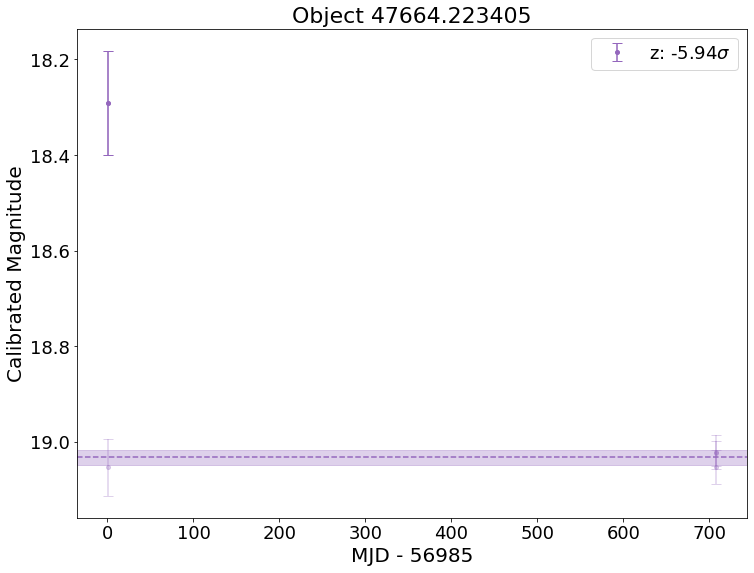

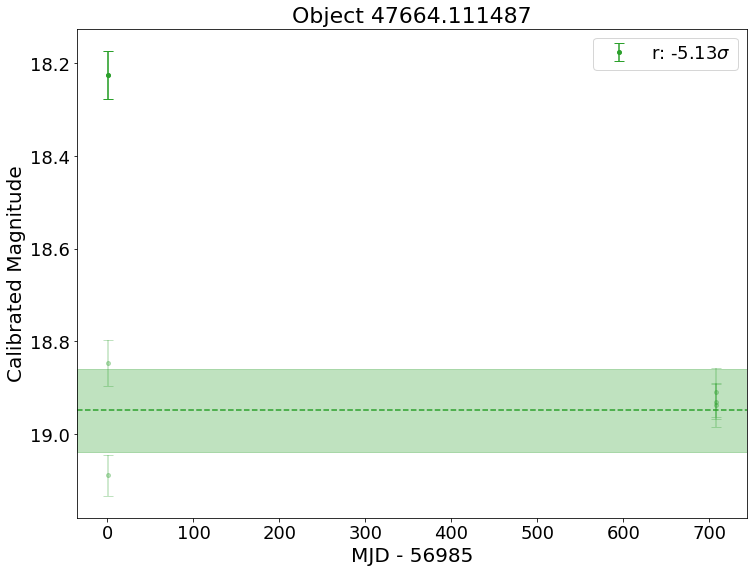

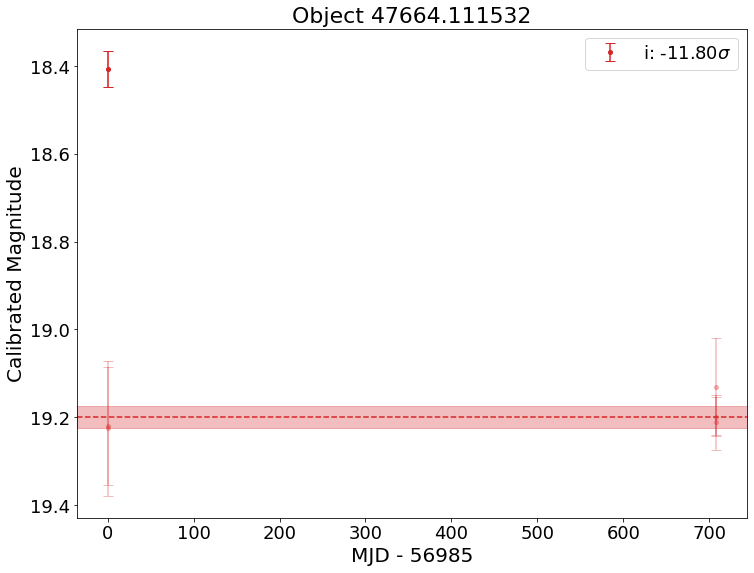

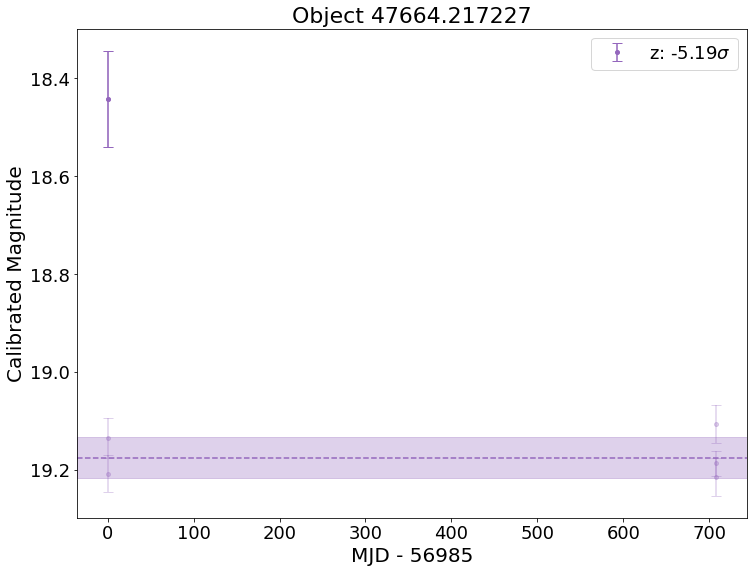

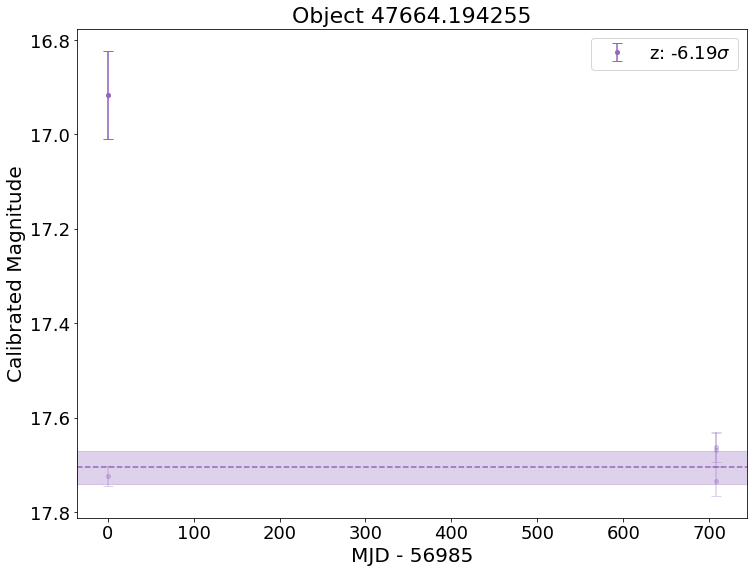

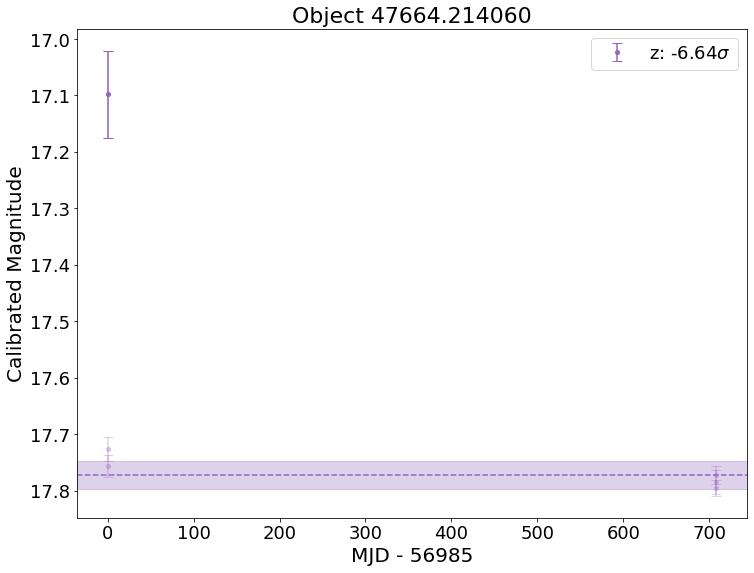

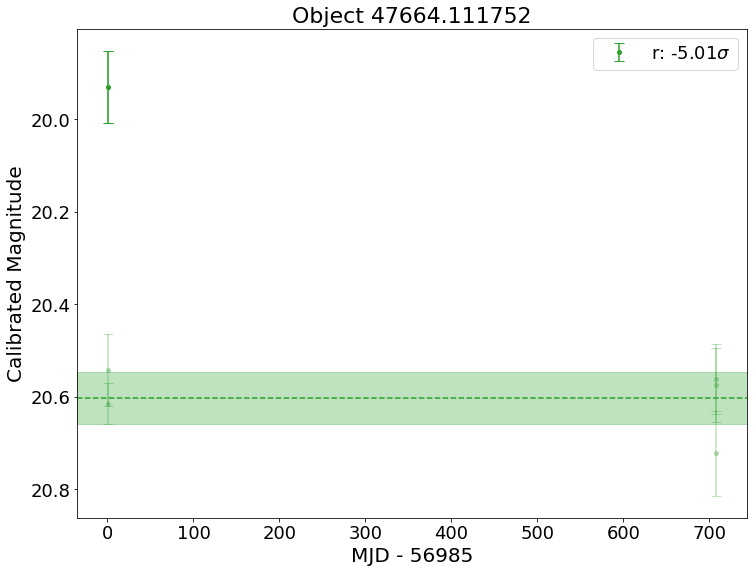

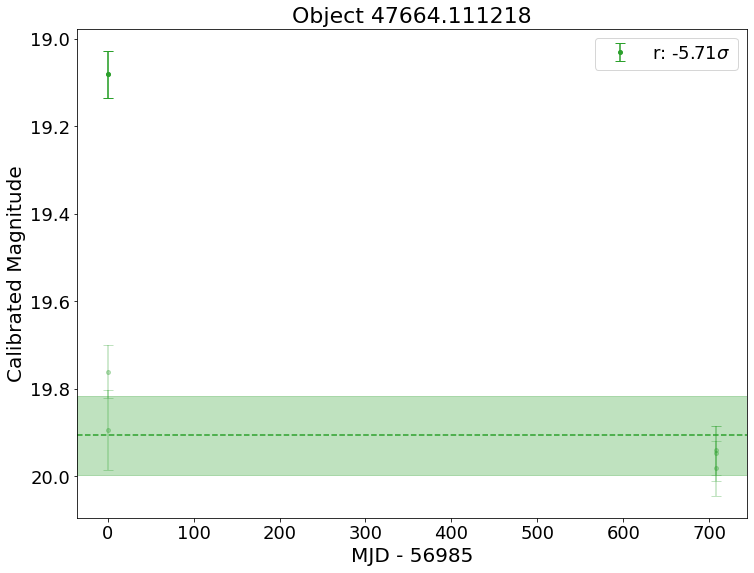

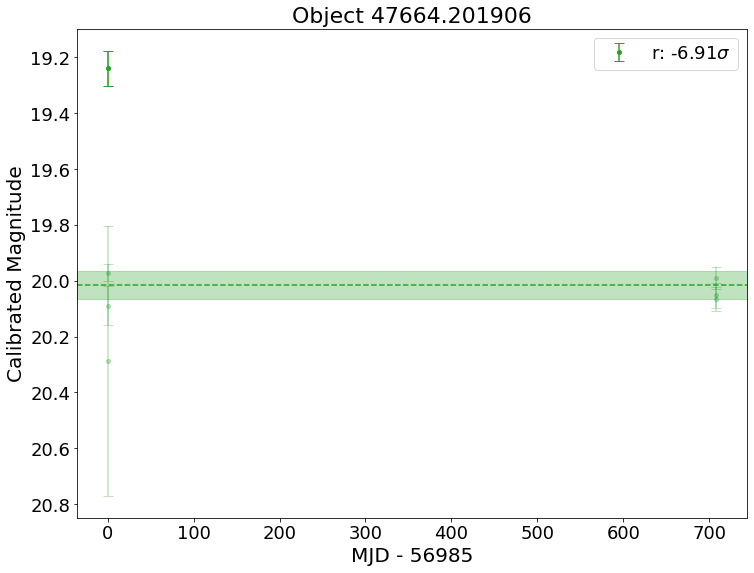

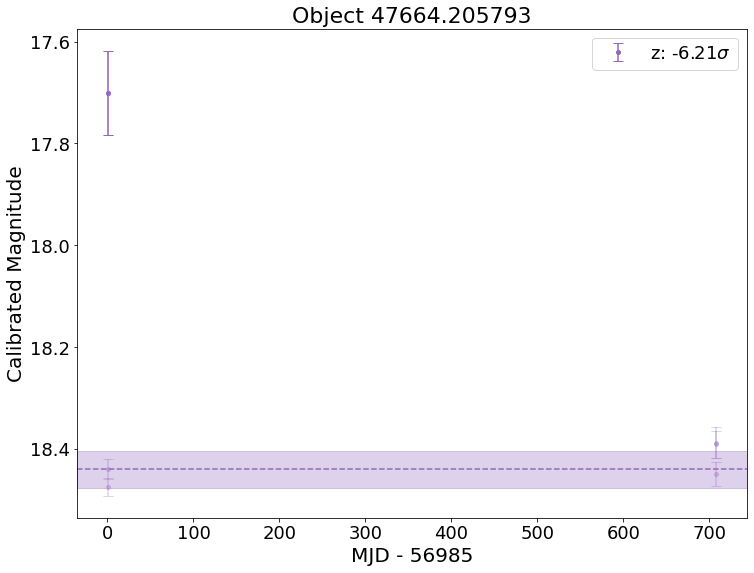

In [6]:
n_to_view = 10
for oid in detected_ids[:n_to_view]:
    plot_lightcurve(lightcurve_df, oid)

## Excursions due to Calibration Error?

### Check PSFs

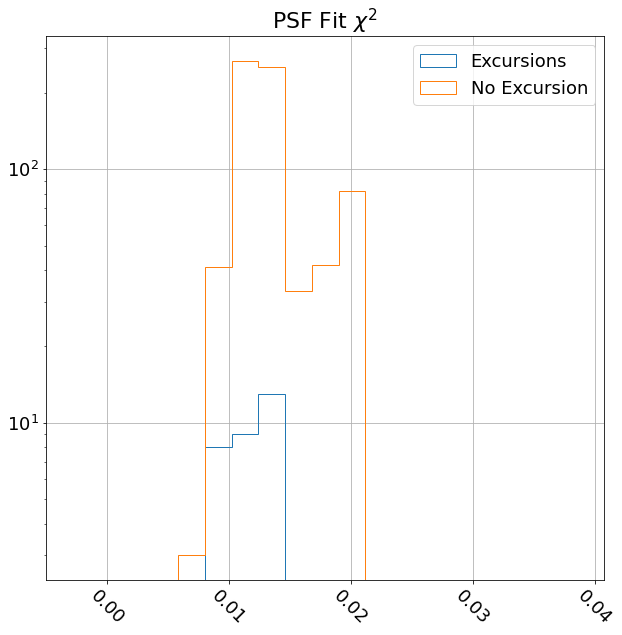

In [8]:
mask_excursion = lightcurve_df["excursion"]
excursion_df = lightcurve_df.loc[mask_excursion]
trigger_ids = lightcurve_df.loc[mask_excursion, "id"].unique()
mask_trigger_id = lightcurve_df["id"].isin(trigger_ids)
no_excursion_df = lightcurve_df.loc[~mask_excursion & mask_trigger_id]
bins = np.linspace(lightcurve_df["dao_psfchi"].min() - 0.01,
                   lightcurve_df["dao_psfchi"].max() + 0.01,
                   num=20)
ax = excursion_df.hist(column="dao_psfchi", figsize=(10, 10), 
                       bins=bins, label="Excursions",
                       histtype="step", stacked=True, log=True)[0, 0]
no_excursion_df.hist(column="dao_psfchi", figsize=(10, 10),
                     bins=bins, label="No Excursion",
                     histtype="step", stacked=True, log=True, ax=ax)
fig = ax.get_figure()
ax.set_title(r"PSF Fit $\chi^2$", fontsize=22)
ax.tick_params(labelsize=18)
ax.tick_params(axis='x', rotation=-45)
ax.legend(fontsize=18, loc="upper right")
# fig.savefig(f"{fig_dir}daopsf_chi2_sample.png")
plt.show(fig)

### Check zero-points

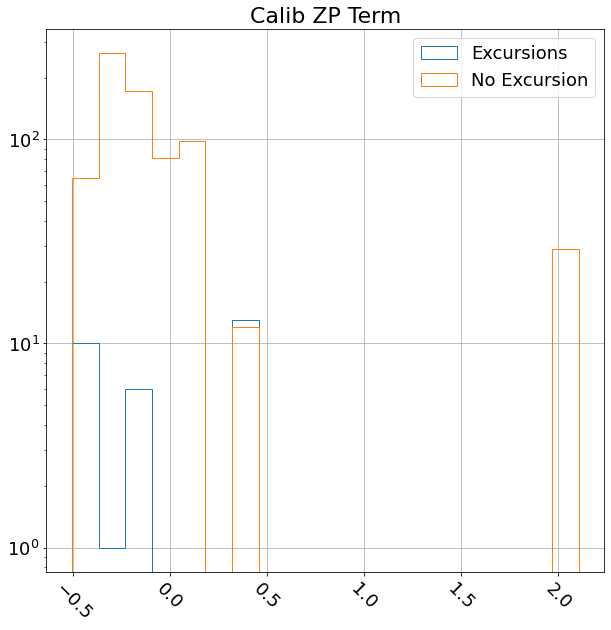

In [9]:
bins = np.linspace(lightcurve_df["calib_zpterm"].min() - 0.001,
                   lightcurve_df["calib_zpterm"].max() + 0.001,
                   num=20)

ax = lightcurve_df.loc[mask_excursion].hist(column="calib_zpterm", figsize=(10, 10), 
                                            bins=bins, label="Excursions",
                                            histtype="step", stacked=True, log=True)[0, 0]
lightcurve_df.loc[mask_trigger_id & ~mask_excursion].hist(column="calib_zpterm",bins=bins, label="No Excursion",
                                                          histtype="step", stacked=True, log=True, ax=ax)
fig = ax.get_figure()
ax.set_title("Calib ZP Term", fontsize=22)
ax.tick_params(labelsize=18)
ax.tick_params(axis='x', rotation=-45)
ax.legend(fontsize=18, loc="upper right")
# fig.savefig(f"{fig_dir}zp_mag_offsets_sample.png")
plt.show(fig)

### On what days do excursions occur?

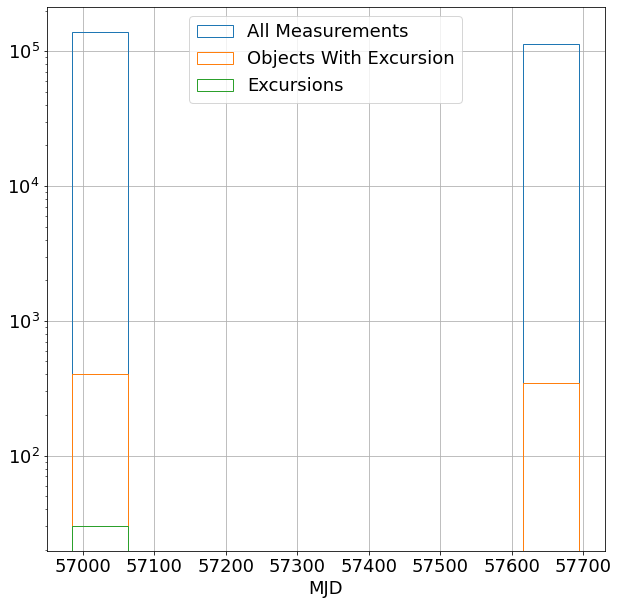

In [19]:
bins = np.linspace(lightcurve_df["mjd"].astype(int).min(), 
                   lightcurve_df["mjd"].astype(int).max() + 1, 10)
mjd_ex = lightcurve_df.loc[mask_excursion, "mjd"].astype(int)
mjd_all = lightcurve_df["mjd"].astype(int)
mjd_id = lightcurve_df.loc[mask_trigger_id, "mjd"].astype(int)

ax_mjd = mjd_all.hist(figsize=(10, 10), label="All Measurements",
                      histtype="step", stacked=True, log=True, bins=bins)
mjd_id.hist(figsize=(10, 10), label="Objects With Excursion",
            histtype="step", stacked=True, log=True, ax=ax_mjd, bins=bins)
mjd_ex.hist(figsize=(10, 10), label="Excursions",
            histtype="step", stacked=True, log=True, ax=ax_mjd, bins=bins)

fig = ax_mjd.get_figure()
ax_mjd.set_xlabel("MJD", fontsize=18)
ax_mjd.tick_params(labelsize=18)
ax_mjd.legend(fontsize=18, loc="upper center")
# fig.savefig(f"{fig_dir}zp_mag_offsets_sample.png")
plt.show(fig)

### Anything interesting in RA Dec Space?

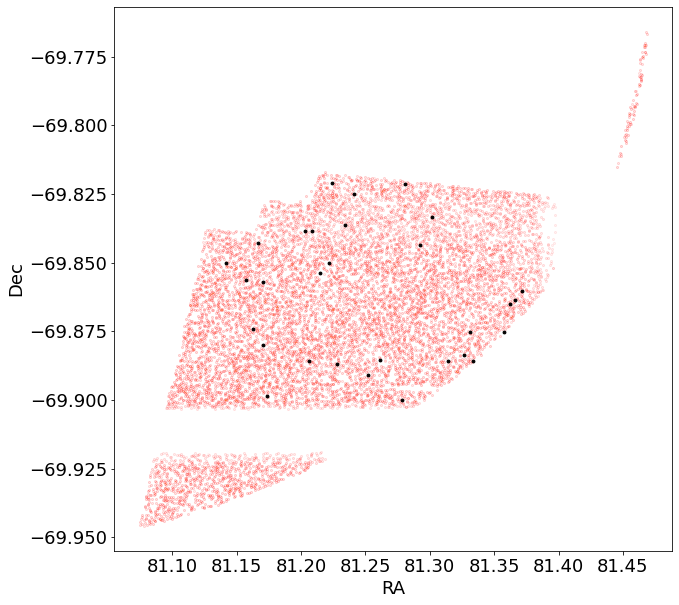

In [20]:
ax = lightcurve_df.loc[~mask_excursion].plot.scatter(x="ra", y="dec", figsize=(10, 10), 
                                             fontsize=18, s=8, alpha=.002, c="tab:orange")
lightcurve_df.loc[mask_excursion].plot.scatter(x="ra", y="dec", figsize=(10, 10), 
                                        fontsize=18, s=8, ax=ax, c="k")
ax.set_xlabel("RA", fontsize=18)
ax.set_ylabel("Dec", fontsize=18)
fig = ax.get_figure()
fig.savefig(f"{fig_dir}outlier_ra_dec_scatter.png")
plt.show(fig)

## Let's look at the images themselves

In [21]:
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/smash_dr2"
svc = sia.SIAService(DEF_ACCESS_URL)

object_id = trigger_ids[1]
mask_object_id = lightcurve_df["id"] == object_id
object_id_str = str(object_id).replace('.', '-')
filt = lightcurve_df.loc[mask_excursion & mask_object_id, "filter"].iloc[0]
mask_object_filter = lightcurve_df["filter"] == filt

obs_dates = np.round(lightcurve_df.loc[mask_object_id & mask_object_filter, "mjd"] + 500000, decimals=8).astype(str)

image_ra = lightcurve_df.loc[mask_excursion & mask_object_id, "ra"].iloc[0]
image_dec = lightcurve_df.loc[mask_excursion & mask_object_id, "dec"].iloc[0]
image_fov = 0.001

imgTable = svc.search((image_ra, image_dec), 
                      (image_fov/np.cos(image_dec*np.pi/180), 
                       image_fov), verbosity=2).to_table()  # uses declination correction

select_filter = imgTable["obs_bandpass"] == filt
select_mjd = np.isin(imgTable["mjd_obs"].data.data, obs_dates)
select_proctype = imgTable["proctype"] == "InstCal"
select_prodtype = imgTable["prodtype"] == "image"
select = select_filter & select_mjd & select_proctype & select_prodtype
table = imgTable[select]
table

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
smash_dr2,"https://datalab.noirlab.edu/svc/cutout?col=smash_dr2&siaRef=c4d_141124_041534_ooi_r_v1.fits.fz&extn=34&POS=81.36264351306804,-69.8652502195662&SIZE=0.0029050412586875828,0.001",image/fits,351959,,,2,0,0,2,[2046 4094],,,[-0.13135],,smash_dr2,,SMASH DR2,archival,,,DECam,r,,,ivo://datalab.noirlab/vo#ivoa_smash_dr2.siav1:ivo://datalab.noao/smash_dr2/c4d_141124_041534_ooi_r_v1.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=smash_dr2&siaRef=c4d_141124_041534_ooi_r_v1.fits.fz&extn=34&POS=81.36264351306804,-69.8652502195662&SIZE=0.0029050412586875828,0.001&preview=true",,,80.9531,-69.8271,--,,,--,5675.0,7155.0,--,--,--,--,--,--,,,,Field41,1.35,SMASH DR2,29.636,image,0.509,0,,60,,InstCal,2014-11-24T04:13:45.356142,556985.1762194,0
smash_dr2,"https://datalab.noirlab.edu/svc/cutout?col=smash_dr2&siaRef=c4d_141124_041234_ooi_r_v1.fits.fz&extn=34&POS=81.36264351306804,-69.8652502195662&SIZE=0.0029050412586875828,0.001",image/fits,343358,,,2,0,0,2,[2046 4094],,,[-0.13136],,smash_dr2,,SMASH DR2,archival,,,DECam,r,,,ivo://datalab.noirlab/vo#ivoa_smash_dr2.siav1:ivo://datalab.noao/smash_dr2/c4d_141124_041234_ooi_r_v1.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=smash_dr2&siaRef=c4d_141124_041234_ooi_r_v1.fits.fz&extn=34&POS=81.36264351306804,-69.8652502195662&SIZE=0.0029050412586875828,0.001&preview=true",,,80.9501,-69.8269,--,,,--,5675.0,7155.0,--,--,--,--,--,--,,,,Field41,1.35,SMASH DR2,28.821,image,0.518,0,,30,,InstCal,2014-11-24T04:11:18.130006,556985.17451539,0
smash_dr2,"https://datalab.noirlab.edu/svc/cutout?col=smash_dr2&siaRef=c4d_161101_081942_ooi_r_v1.fits.fz&extn=34&POS=81.36264351306804,-69.8652502195662&SIZE=0.0029050412586875828,0.001",image/fits,375480,,,2,0,0,2,[2046 4094],,,[-0.13116],,smash_dr2,,SMASH DR2,archival,,,DECam,r,,,ivo://datalab.noirlab/vo#ivoa_smash_dr2.siav1:ivo://datalab.noao/smash_dr2/c4d_161101_081942_ooi_r_v1.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=smash_dr2&siaRef=c4d_161101_081942_ooi_r_v1.fits.fz&extn=34&POS=81.36264351306804,-69.8652502195662&SIZE=0.0029050412586875828,0.001&preview=true",,,80.9663,-69.8301,--,,,--,5675.0,7155.0,--,--,--,--,--,--,,,,Field41,1.31,SMASH DR2,31.291,image,0,0,,267,,InstCal,2016-11-01T08:14:27.687426,557693.34337601,0
smash_dr2,"https://datalab.noirlab.edu/svc/cutout?col=smash_dr2&siaRef=c4d_161101_081446_ooi_r_v1.fits.fz&extn=34&POS=81.36264351306804,-69.8652502195662&SIZE=0.0029050412586875828,0.001",image/fits,378708,,,2,0,0,2,[2046 4094],,,[-0.13117],,smash_dr2,,SMASH DR2,archival,,,DECam,r,,,ivo://datalab.noirlab/vo#ivoa_smash_dr2.siav1:ivo://datalab.noao/smash_dr2/c4d_161101_081446_ooi_r_v1.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=smash_dr2&siaRef=c4d_161101_081446_ooi_r_v1.fits.fz&extn=34&POS=81.36264351306804,-69.8652502195662&SIZE=0.002905041

### InstCal images

Exposure time: 30s


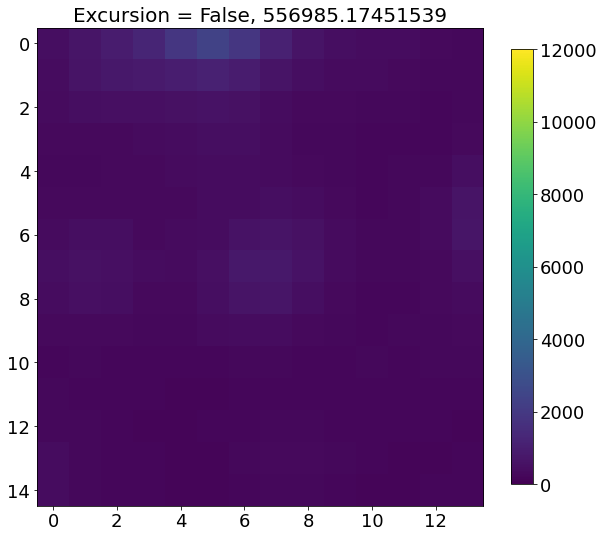

Exposure time: 60s


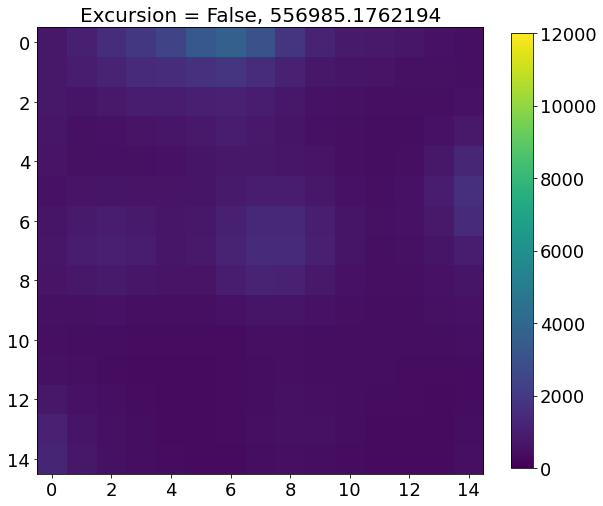

Exposure time: 60s


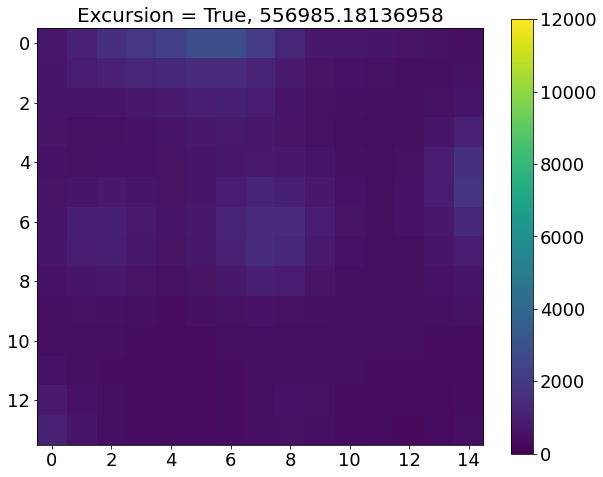

Exposure time: 267s


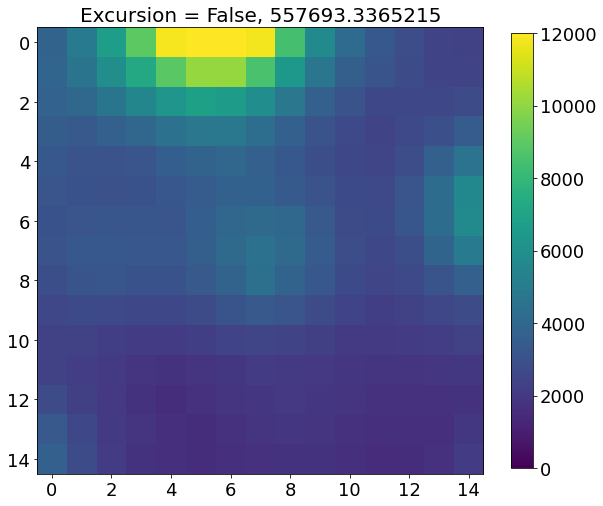

Exposure time: 267s


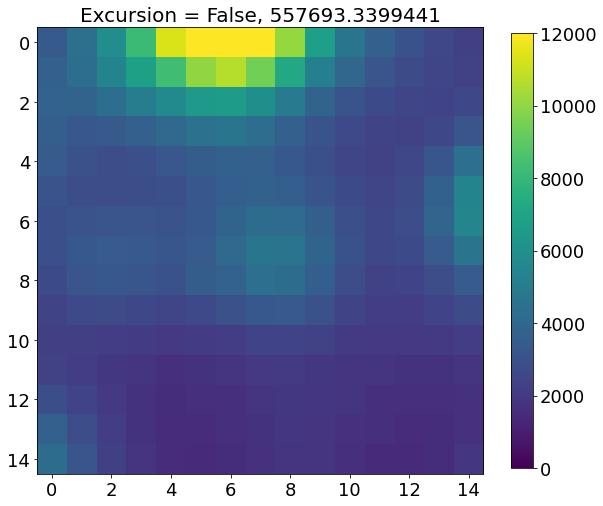

Exposure time: 267s


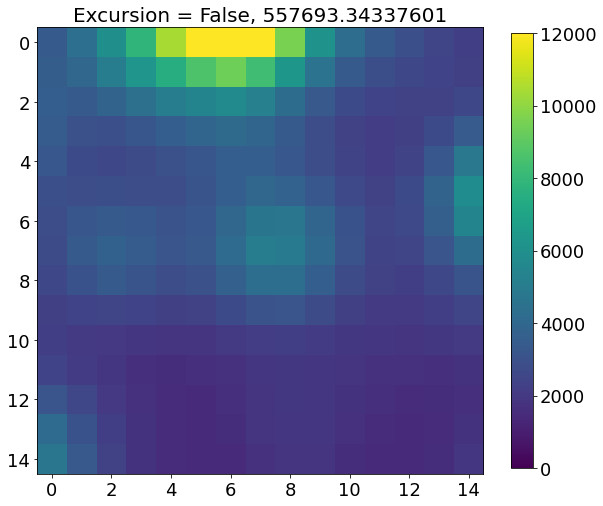

In [22]:
images = []
exposure_times = []

for date in np.sort(table["mjd_obs"].data.data):
    row = table[table["mjd_obs"] == date][0]
    mask_object_date = np.round(lightcurve_df.loc[mask_object_id & mask_object_filter, "mjd"] + 500000, 
                                decimals=8).astype(str) == date
    excursion = lightcurve_df.loc[mask_object_id & mask_object_filter & mask_object_date, "excursion"].iloc[0]
    url = row["access_url"]
    exposure_time = row["exptime"]
    print(f"Exposure time: {exposure_time}s")
    file = utils.data.download_file(url, cache=True, timeout=300)
    im = io.fits.getdata(file)
    fig, ax = plt.subplots(figsize=(10, 10))
    axim = ax.imshow(im, vmin=0, vmax=12000)
    cbar = fig.colorbar(axim, ax=ax, shrink=0.8)
    ax.tick_params(labelsize=18)
    ax.set_title(f"Excursion = {excursion}, {date}", fontsize=20)
    cbar.ax.tick_params(labelsize=18)
    images.append(im)
    exposure_times.append(exposure_time)
    plt.show(fig)

### InstCal scaled by exposure time

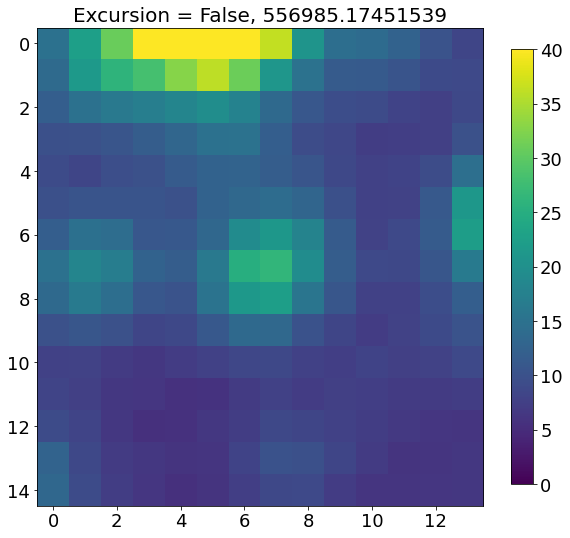

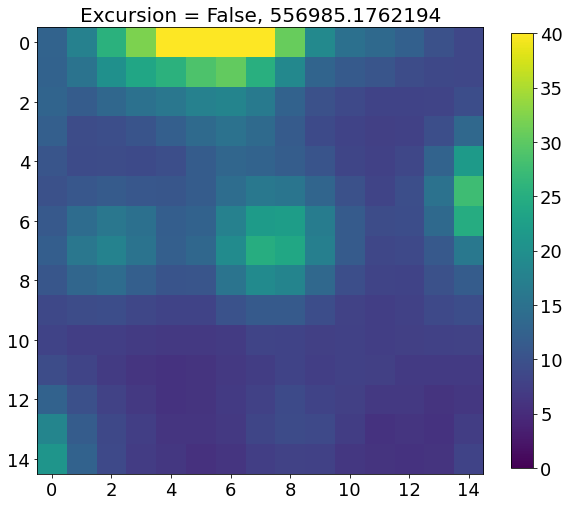

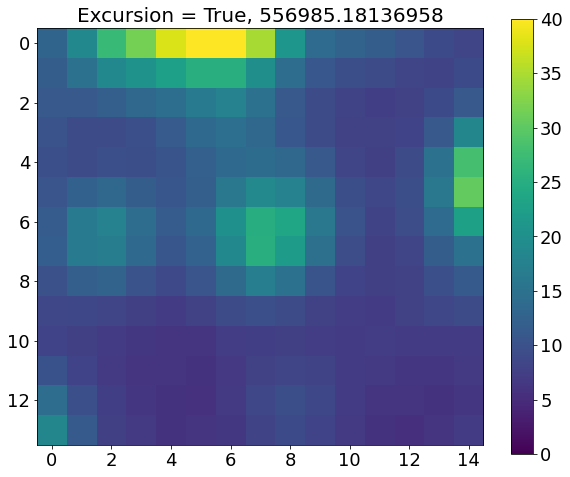

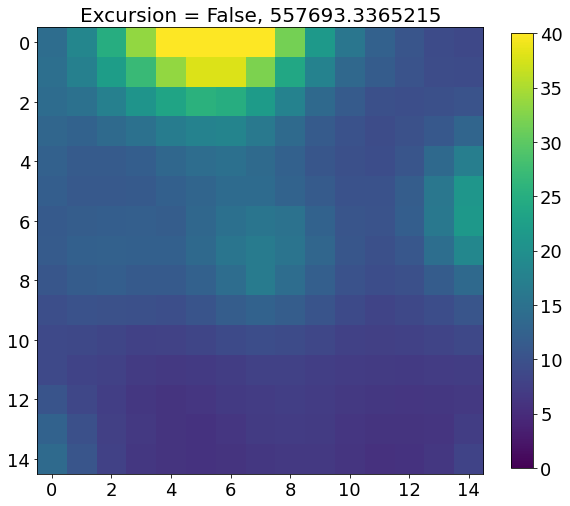

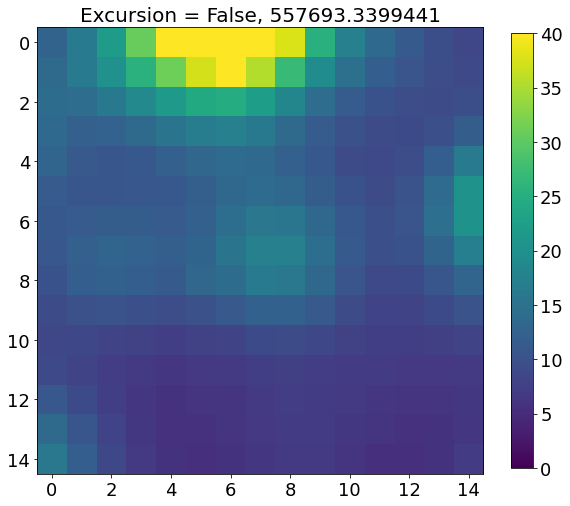

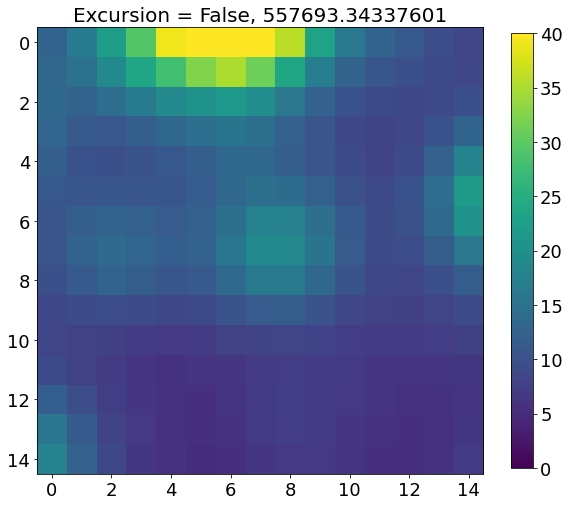

In [23]:
for i, date in enumerate(np.sort(table["mjd_obs"].data.data)):
    row = table[table["mjd_obs"] == date][0]
    mask_object_date = np.round(lightcurve_df.loc[mask_object_id & mask_object_filter, "mjd"] + 500000, 
                                decimals=8).astype(str) == date
    excursion = lightcurve_df.loc[mask_object_id & mask_object_filter & mask_object_date, "excursion"].iloc[0]
    exposure_time = exposure_times[i]
    im = images[i] / int(exposure_time)
    fig, ax = plt.subplots(figsize=(10, 10))
    axim = ax.imshow(im, vmin=0, vmax=40)
    cbar = fig.colorbar(axim, ax=ax, shrink=0.8)
    ax.tick_params(labelsize=18)
    ax.set_title(f"Excursion = {excursion}, {date}", fontsize=20)
    cbar.ax.tick_params(labelsize=18)
    plt.show(fig)
#     fig.savefig(f"{fig_dir}{object_id_str}_image_exptime_scaled{i}.png")

### What's the dataframe for this object look like?

In [24]:
lightcurve_df.loc[mask_object_filter & mask_object_id, ["excursion", "forced", "mjd", "prob",  "cmag", "mag", "calib_zpterm", "exptime"]]

,excursion,forced,mjd,prob,cmag,mag,calib_zpterm,exptime
18912,False,1,57693.339944,0.02,18.937155,12.549,-0.365502,267
18913,False,1,57693.336522,0.02,18.930456,12.574,-0.318202,267
18914,False,1,57693.343376,0.02,18.909750,12.523,-0.356589,267
18917,True,0,56985.181370,-1.00,18.224636,13.218,-0.466372,60
18919,False,0,56985.174515,-1.00,19.089025,15.018,-0.349500,30
18921,False,0,56985.176219,-1.00,18.845715,14.011,-0.406096,60


### Plot the quotient images

In [25]:
for im in images:
    print(im.shape)

(15, 14)
(15, 15)
(14, 15)
(15, 15)
(15, 15)
(15, 15)


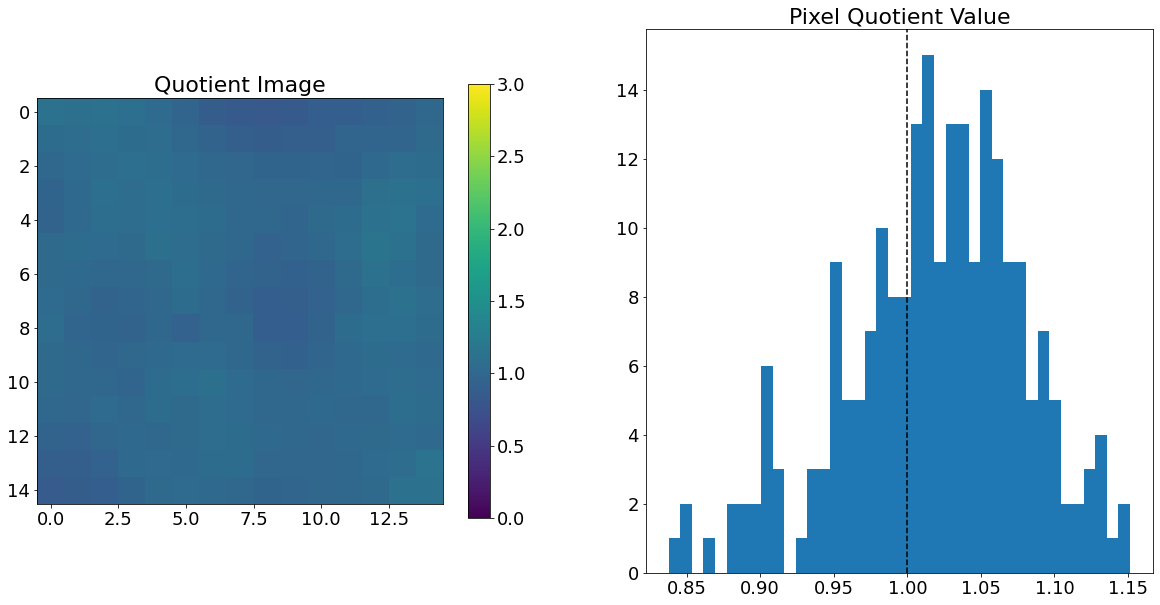

In [26]:
exposure_times_array = np.array(exposure_times[:-2]).astype(int)
quotient_images = [images[3] / images[4]]
quotient_times = [float(exposure_times[3]) / float(exposure_times[4])]

for i, (q_image, q_exp_time) in enumerate(zip(quotient_images, quotient_times)):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axim = axes[0].imshow(q_image, vmin=0, vmax=3)
    cbar = fig.colorbar(axim, ax=axes[0], shrink=0.8)
    cbar.ax.tick_params(labelsize=18)
    axes[0].set_title("Quotient Image", fontsize=22)
    axes[1].hist(q_image.flatten(), bins=40)
    axes[1].axvline(q_exp_time, c='k', ls="--")
    axes[1].set_title("Pixel Quotient Value", fontsize=22)

    for ax in axes.ravel():
        ax.tick_params(labelsize=18)
    plt.show(fig)
#     fig.savefig(f"{fig_dir}{object_id_str}_quotient_image{i}.png")

## Plot the lightcurve for this object.

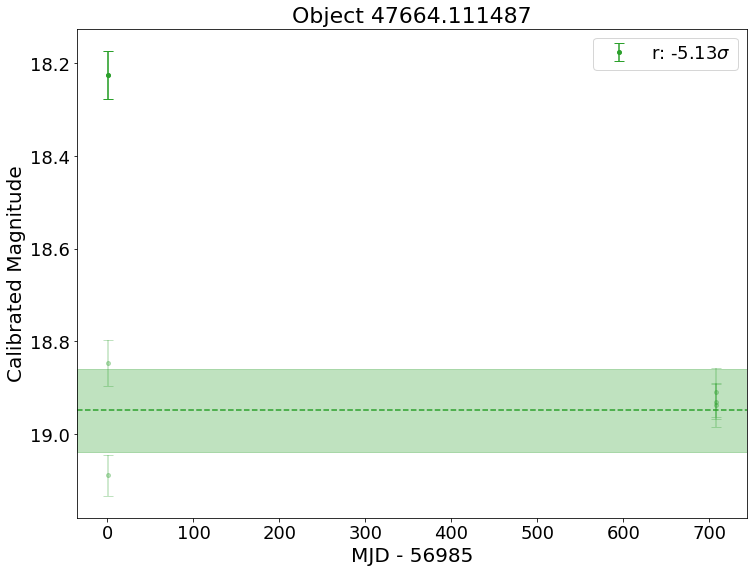

In [27]:
plot_lightcurve(lightcurve_df, object_id)

## How many measurements have forced photometry?

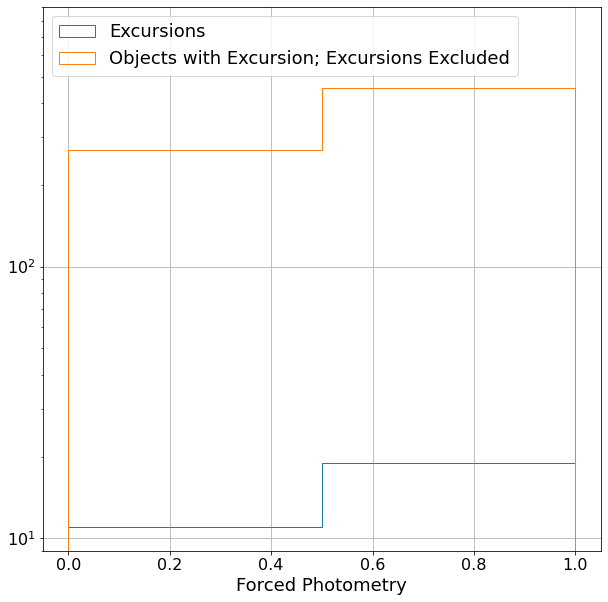

In [31]:
bins = np.arange(0, 1.5, 0.5)
fig, ax = plt.subplots(figsize=(10, 10))

lightcurve_df.loc[mask_excursion].hist(column="forced", ax=ax, bins=bins, 
                                       histtype="step", stacked=True, label="Excursions", log=True)
lightcurve_df.loc[~mask_excursion & mask_trigger_id].hist(column="forced", ax=ax, bins=bins, log=True,
                                                          histtype="step", stacked=True, label="Objects with Excursion; Excursions Excluded")
ax.set_xlabel(f"Forced Photometry", fontsize=18)
ax.tick_params(labelsize=16)
ax.set_ylim(9, 900)
ax.legend(loc="upper left", fontsize=18)
ax.set_title("")
plt.show(fig)

## How many have forced photometry on a night where every other measurement does not?

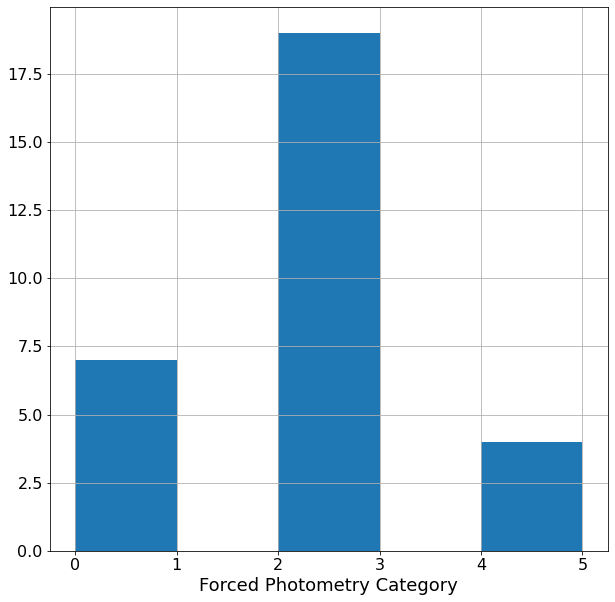

In [57]:
# column_list = ["apcor", "ubercal_magoffset", "calib_zpterm", "skymode"]
pre_aggregate_df = lightcurve_df.copy()
pre_aggregate_df["mjd"] = pre_aggregate_df["mjd"].astype(int)
# mean_differences = pre_aggregate_df.loc[mask_trigger_id].groupby(["id", "mjd", "filter"]).apply(aggregator, column_list)
forced_df = pre_aggregate_df.loc[mask_trigger_id].groupby(["id", "mjd", "filter"]).apply(aggregator2)

bins = np.arange(6)
forced_df = forced_df.dropna()
fig, ax = plt.subplots(figsize=(10, 10))

forced_df.hist(ax=ax, bins=bins)
ax.set_xlabel(f"Forced Photometry Category", fontsize=18)
ax.tick_params(labelsize=16)
ax.set_title("")
# fig.savefig(f"{fig_dir}forced_photometry_category_hist.png")
plt.show(fig)

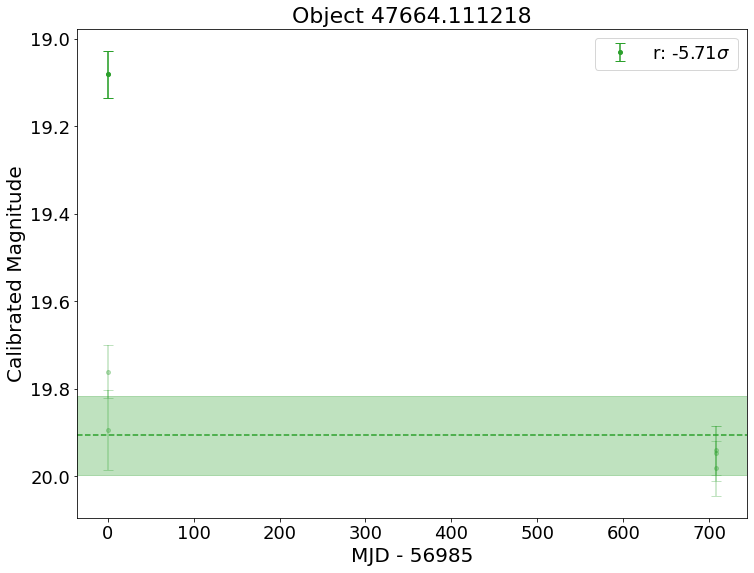

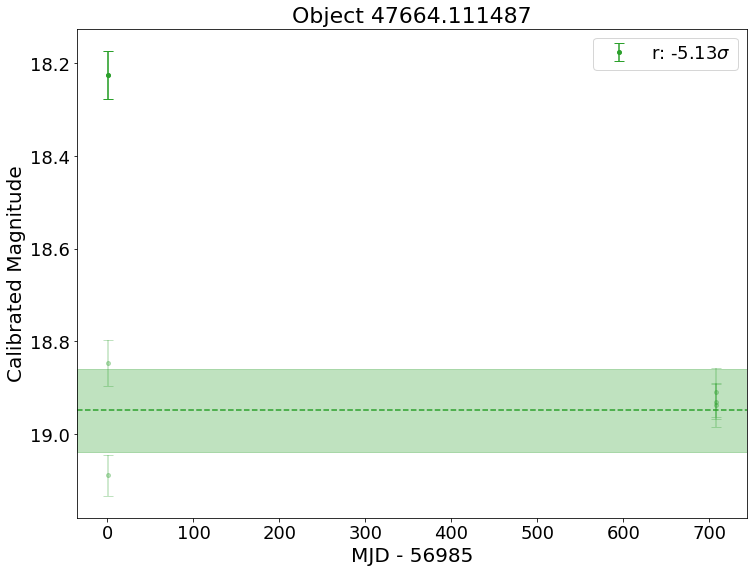

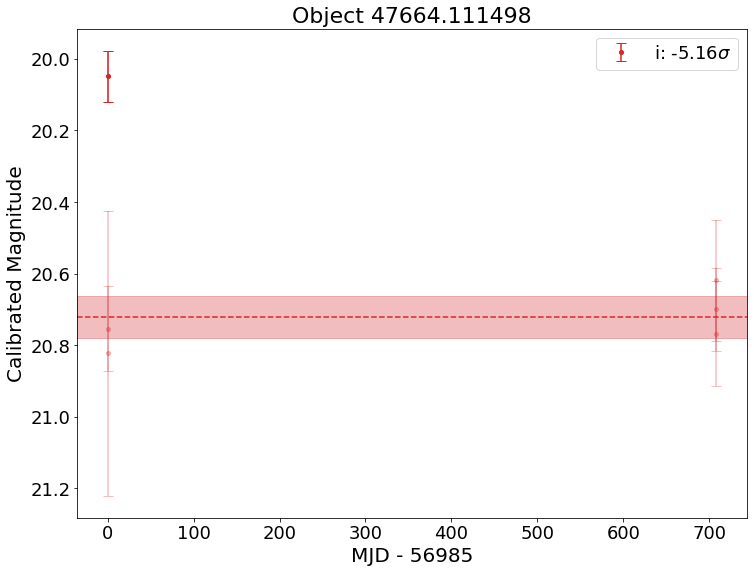

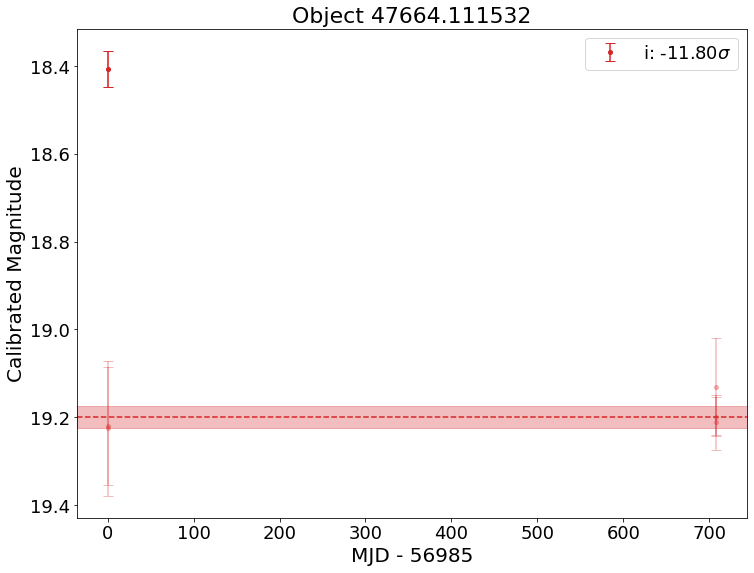

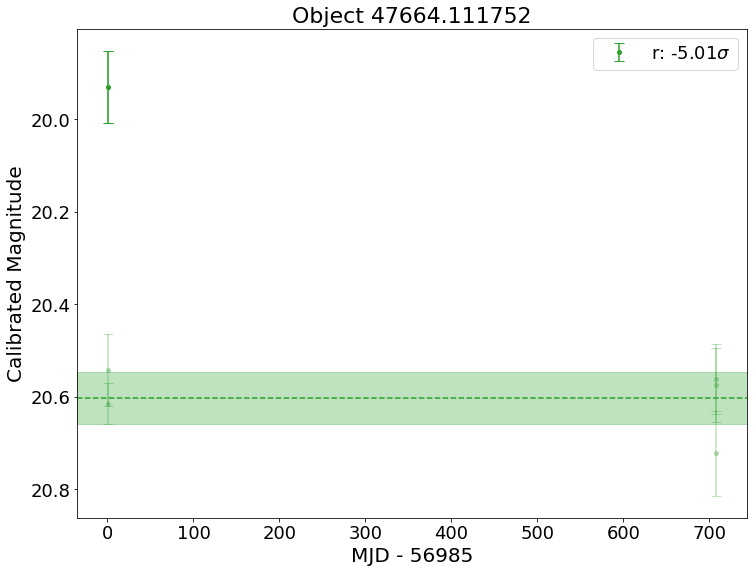

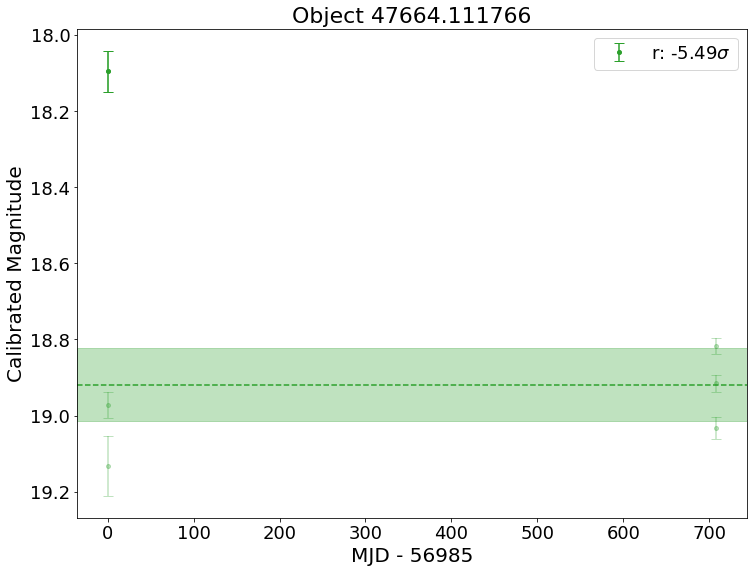

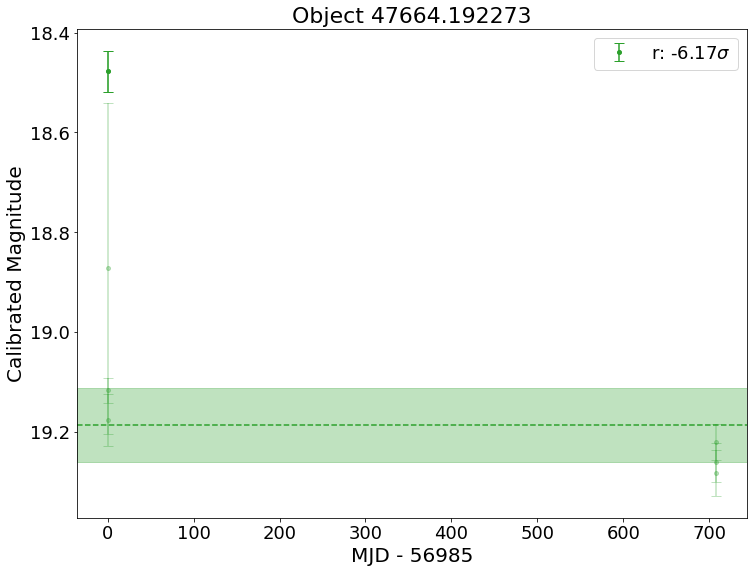

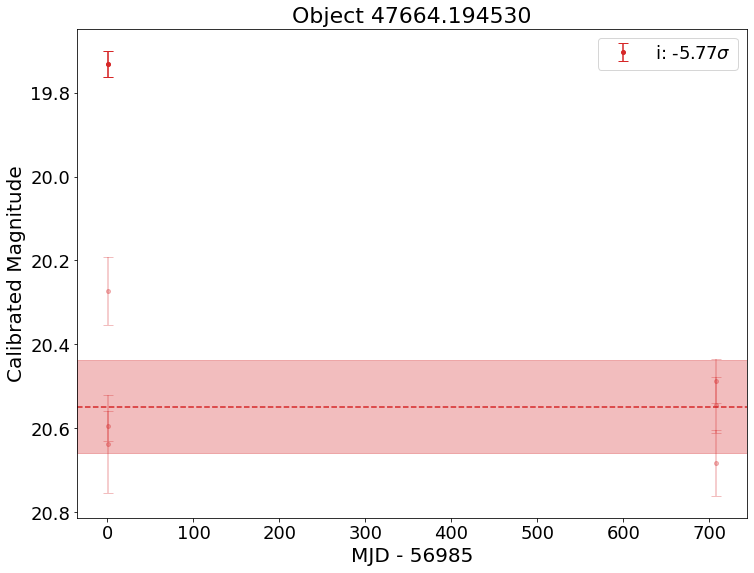

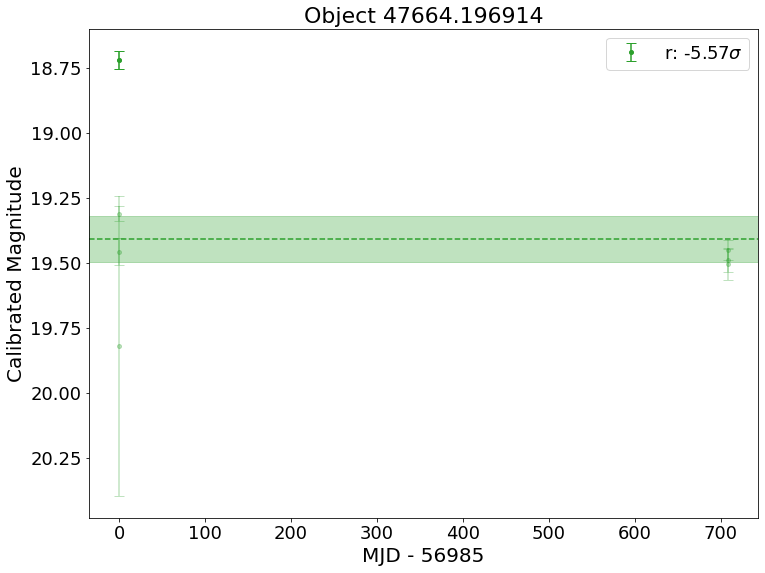

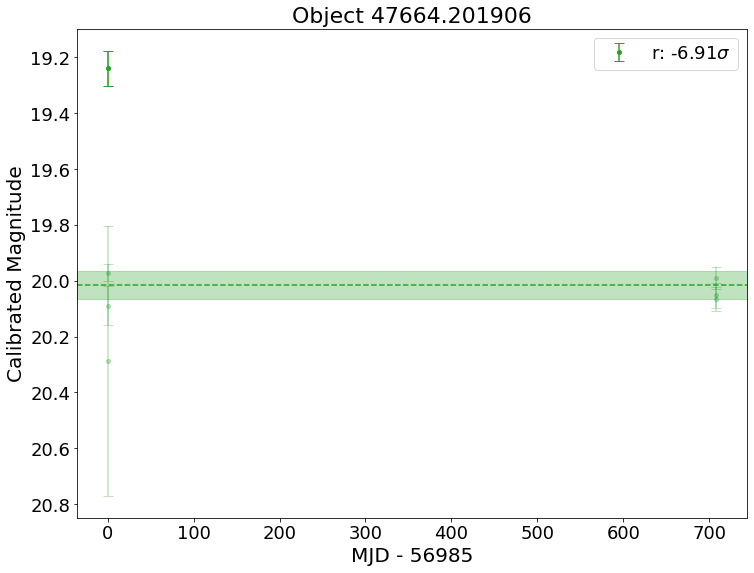

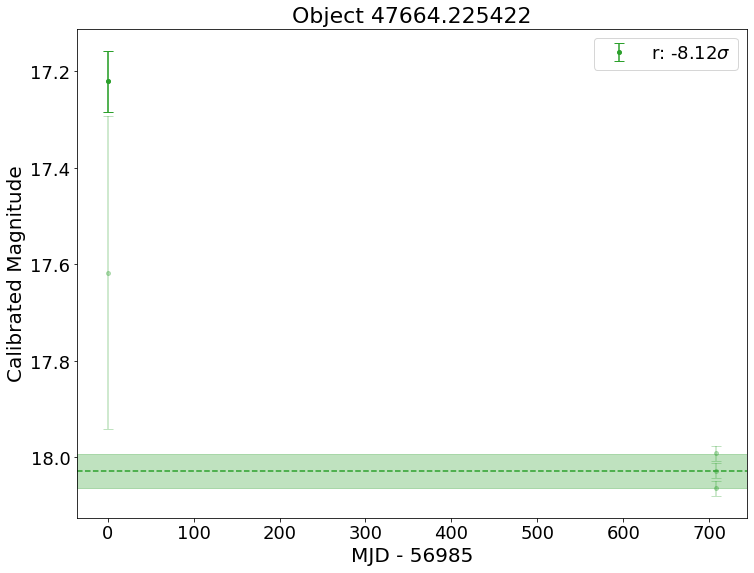

In [58]:
mask_not_cat_2_id = forced_df != 2
background_ids = forced_df[mask_not_cat_2_id].index.get_level_values("id").unique().values
for background_id in background_ids:
    plot_lightcurve(lightcurve_df, background_id)

## What's the stellaricity probability of my objects?

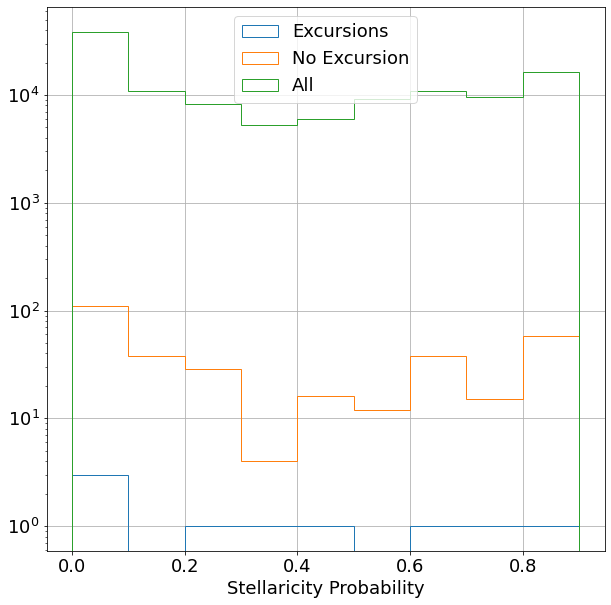

In [59]:
sextractor_mask = lightcurve_df["prob"] >= 0
trigger_probs = lightcurve_df.loc[mask_excursion & sextractor_mask, "prob"]
no_trigger_probs = lightcurve_df.loc[mask_trigger_id & ~mask_excursion & sextractor_mask, "prob"]
all_probs = lightcurve_df.loc[sextractor_mask, "prob"]

bins = np.arange(0, 1, 0.1)

ax = trigger_probs.hist(figsize=(10, 10), label="Excursions", bins=bins,
                        histtype="step", stacked=True, log=True)
no_trigger_probs.hist(figsize=(10, 10), label="No Excursion", bins=bins,
                      histtype="step", stacked=True, log=True, ax=ax)
all_probs.hist(figsize=(10, 10), label="All", bins=bins,
               histtype="step", stacked=True, log=True, ax=ax)

fig = ax.get_figure()
ax.set_xlabel("Stellaricity Probability", fontsize=18)
ax.tick_params(labelsize=18)
ax.legend(fontsize=18, loc="upper center")
# fig.savefig(f"{fig_dir}zp_mag_offsets_sample.png")
plt.show(fig)

In [61]:
object_query = f"""
SELECT id, prob FROM smash_dr2.object
WHERE 't' = Q3C_RADIAL_QUERY(ra, dec, {lmc_ra}, {lmc_dec}, {search_radius})
AND (ndetu > {n_detections} OR ndetg > {n_detections} OR ndetr > {n_detections} 
OR ndeti > {n_detections} OR ndetz > {n_detections})
LIMIT 10000
"""

object_df = qc.query(sql=object_query, fmt="pandas")

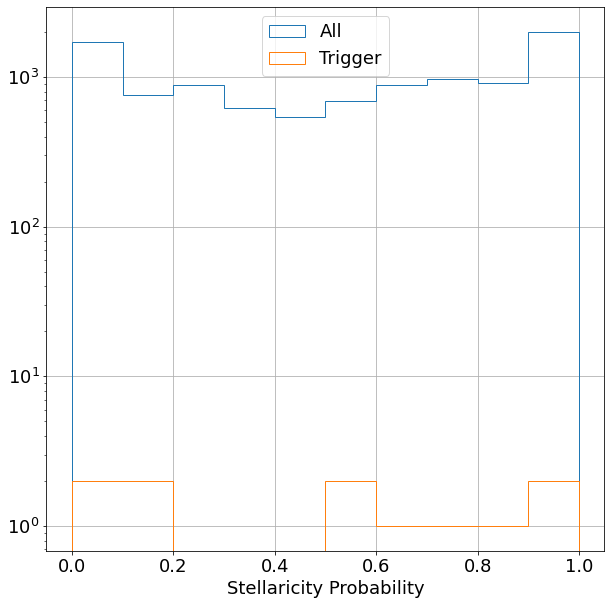

In [70]:
mask_object_trigger = object_df["id"].isin(background_ids)
all_probs = object_df["prob"]
trigger_probs = object_df.loc[mask_object_trigger, "prob"]
bins = np.arange(0, 1.1, 0.1)

ax = all_probs.hist(figsize=(10, 10), label="All", bins=bins,
                        histtype="step", stacked=True, log=True)
trigger_probs.hist(label="Trigger", bins=bins,
                   histtype="step", stacked=True, log=True, ax=ax)

fig = ax.get_figure()
ax.set_xlabel("Stellaricity Probability", fontsize=18)
ax.tick_params(labelsize=18)
ax.legend(fontsize=18, loc="upper center")
# fig.savefig(f"{fig_dir}zp_mag_offsets_sample.png")
plt.show(fig)

In [69]:
trigger_probs

1069    0.790714
1172    0.964118
1379    0.884286
1425    0.545000
1489    0.940000
2152    0.152857
2172    0.585000
2253    0.671538
4216    0.148000
4965    0.019231
9075    0.085714
Name: prob, dtype: float64

### Histogram of Delta Mags

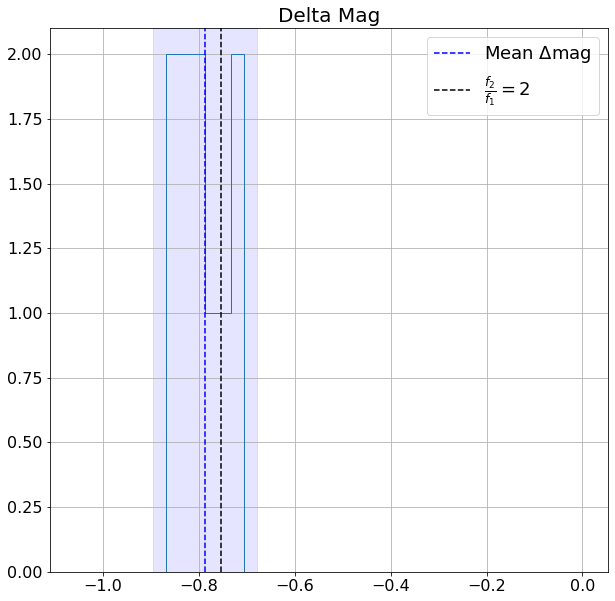

In [21]:
n_excursions = len(excursion_df)
d = {"delta_mag": np.zeros((n_excursions)), "delta_mag_err": np.zeros((n_excursions))}
delta_mag_df = pd.DataFrame(data=d)

for i, row in enumerate(excursion_df.itertuples()):
    mask_id = lightcurve_df["id"] == row.id
    source_lc_df = lightcurve_df.loc[mask_id]
    filters_with_excursion = source_lc_df.loc[source_lc_df["excursion"], "filter"]
    
    for f in filters_with_excursion:
        m = filters == f
        mask_filter = mask_filters[m]
        mask = mask_id & mask_filter
        mask_exc = mask & lightcurve_df["excursion"]
        lightcurve_full = lightcurve_df.loc[mask]
        lightcurve_exc = lightcurve_df.loc[mask_exc]
        vals = lightcurve_df.loc[(mask & ~lightcurve_df["excursion"]), "cmag"].values
        weights = (lightcurve_df.loc[(mask & ~lightcurve_df["excursion"]), "cerr"].values)**-2
        w_mean = (weights * vals).sum() / weights.sum()
        w_sigma = np.sqrt(1 / weights.sum())
        delta_mag_df.at[i, "delta_mag"] = lightcurve_exc["cmag"].values[0] - w_mean
        delta_mag_df.at[i, "delta_mag_err"] = lightcurve_exc["cerr"].values[0] + w_sigma

delta_mag = delta_mag_df["delta_mag"].values
weights = np.power(delta_mag_df["delta_mag_err"].values, -2)
delta_mag_wmean = (delta_mag * weights).sum() / weights.sum()
delta_mag_wsigma = delta_mag_df["delta_mag_err"].mean()

flux_doubling = -2.5 * np.log10(2)

hist_bins = np.linspace(delta_mag_df["delta_mag"].min() - 0.2, 0, num=40)
hist = delta_mag_df.hist(column="delta_mag", xlabelsize=16, ylabelsize=16, 
                         figsize=(10, 10), bins=hist_bins, histtype="step")[0, 0]
fig = hist.get_figure()
hist.set_title("Delta Mag", fontsize=20)
hist.axvline(delta_mag_wmean, linestyle="--", color='b', label=r"Mean $\Delta$mag")
hist.axvline(flux_doubling, linestyle="--", color='k', label=r"$\frac{f_2}{f_1} = 2$")
hist.axvspan(delta_mag_wmean - delta_mag_wsigma,
              delta_mag_wmean + delta_mag_wsigma, alpha=0.1, color='b')
hist.legend(loc="upper right", fontsize=18)
plt.show(fig)
# fig.savefig(f"{fig_dir}delta_mag_hist1.png")

# Gaia

In [44]:
gaia_search_radius = 2
gaia_bands = np.array(["RP", "G", "BP"])

gaia_sub_query = f"""
SELECT source_id FROM gaia_dr2.gaia_source
    WHERE 't' = Q3C_RADIAL_QUERY(ra, dec, {lmc_ra}, {lmc_dec}, {gaia_search_radius})
        AND parallax_over_error != 'NaN'
"""

gaia_query = f"""
SELECT GLC.band, GLC.time, GLC.flux, GLC.flux_error, 
    GLC.mag, GLC.source_id, GS.parallax, GS.parallax_error, GS.parallax_over_error
    FROM (
        SELECT * FROM gaia_dr2.light_curves AS LC
            WHERE LC.source_id IN ({gaia_sub_query})) AS GLC
    INNER JOIN gaia_dr2.gaia_source as GS
        ON GLC.source_id = GS.source_id
"""

gaia_lightcurve_df = qc.query(sql=gaia_query, fmt="pandas")

In [82]:
mask_filters = np.array([gaia_lightcurve_df["band"] == b for b in gaia_bands])
gaia_lightcurve_df["excursion"] = False

for source_id in gaia_lightcurve_df["source_id"].unique():
    mask_id = gaia_lightcurve_df["source_id"] == source_id

    for mask_filter in mask_filters:
        mask = mask_id & mask_filter
        lc = gaia_lightcurve_df.loc[mask]
        n_samples = len(lc)

        if n_samples >= n_detections:
            samples = -2.5 * np.log10(lc["flux"].values)
            errs = (2.5 * lc["flux_error"] / (np.log(10) * lc["flux"])).values
            gaia_lightcurve_df.loc[mask, "excursion"] = detect_excursions(samples, errs)

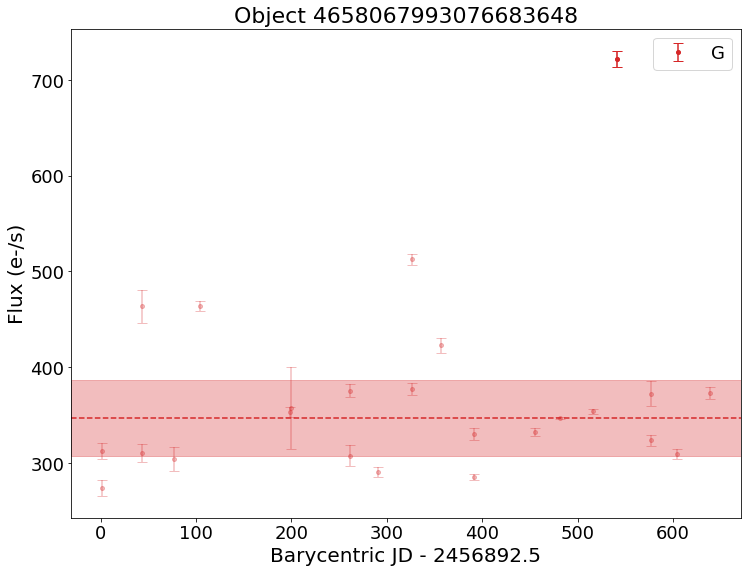

In [88]:
gaia_colors = np.array(["tab:blue", "tab:red", "tab:green"])
gaia_detected_ids = gaia_lightcurve_df.loc[gaia_lightcurve_df["excursion"], "source_id"].unique()
min_time = gaia_lightcurve_df["time"].astype(int).min()
time_offset = min_time + 2455197.5

for oid in gaia_detected_ids:
    fig, ax = plt.subplots(figsize=(12, 9))

    oid_str = str(oid).replace('.', '-')
    mask_id = gaia_lightcurve_df["source_id"] == oid
    source_lc_df = gaia_lightcurve_df.loc[mask_id]
    filters_with_excursion = source_lc_df.loc[source_lc_df["excursion"], "band"]
    
    for f in filters_with_excursion:
        m = gaia_bands == f
        c = gaia_colors[m][0]
        mask_filter = mask_filters[m]
        mask = mask_id & mask_filter
        mask_exc = mask & gaia_lightcurve_df["excursion"]
        
        gaia_lightcurve_full = gaia_lightcurve_df.loc[mask]

        gaia_lightcurve_exc = gaia_lightcurve_df.loc[mask_exc]
        
        vals = gaia_lightcurve_df.loc[(mask & ~gaia_lightcurve_df["excursion"]), "flux"].values
        errs = gaia_lightcurve_df.loc[(mask & ~gaia_lightcurve_df["excursion"]), "flux_error"].values
        weights = np.power(errs, -2)
        w_mean = weighted_mean(vals, weights)
        w_sigma = weighted_std(vals, weights)

        ax.errorbar(gaia_lightcurve_full["time"] - min_time, gaia_lightcurve_full['flux'], 
                    yerr=gaia_lightcurve_full["flux_error"],
                    marker='.', ms=8, capsize=5, color=c, ls="None", alpha=0.3)

        ax.errorbar(gaia_lightcurve_exc["time"] - min_time, gaia_lightcurve_exc['flux'], 
                    yerr=gaia_lightcurve_exc["flux_error"],
                    marker='.', ms=8, capsize=5, color=c, 
                    label=f"{f}", ls="None")
        
        ax.axhline(w_mean, color=c, linestyle='--')
        ax.axhspan(w_mean - w_sigma, w_mean + w_sigma, color=c, alpha=0.3)

    ax.set_xlabel(f'Barycentric JD - {time_offset}', fontsize=20)
    ax.set_ylabel('Flux (e-/s)', fontsize=20)
    ax.legend(fontsize=18)
    ax.tick_params(labelsize=18)
    ax.set_title(f"Object {oid}", fontsize=22)
    fig.savefig(f"{fig_dir}gaia_{oid_str}_kde_detection_lightcurve.png")
    plt.show(fig)